In [30]:
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from numpy import linalg as LA
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from keras_vggface.vggface import VGGFace
from keras.engine import Model
from sklearn.model_selection import KFold
import keras.metrics as metrics
from keras_vggface import utils

In [2]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [16]:
img_list = []
y_list = []
ref = {}
i = 0
for file in os.listdir("Cropped/"):
    yi = int(file.split('_')[0]) - 1 
#     image = cv2.imread("Cropped/"+ file)
# #     image = cv2.imread("Cropped/"+ file)
#     image = cv2.resize(image,(224,224))
    img = preprocess_image("Cropped/"+ file)[0,:]
    img_list.append(img)
    ref[i] = file.split('_')[0]
    y_list.append(yi)
    i+=1
X = np.array(img_list)
y = np.array(y_list)

In [4]:
ref

{0: '121',
 1: '164',
 2: '075',
 3: '130',
 4: '066',
 5: '023',
 6: '060',
 7: '160',
 8: '003',
 9: '188',
 10: '022',
 11: '103',
 12: '186',
 13: '084',
 14: '167',
 15: '079',
 16: '034',
 17: '044',
 18: '001',
 19: '171',
 20: '103',
 21: '146',
 22: '172',
 23: '072',
 24: '063',
 25: '111',
 26: '011',
 27: '126',
 28: '159',
 29: '139',
 30: '039',
 31: '018',
 32: '127',
 33: '144',
 34: '162',
 35: '044',
 36: '060',
 37: '025',
 38: '127',
 39: '138',
 40: '027',
 41: '180',
 42: '082',
 43: '059',
 44: '056',
 45: '156',
 46: '042',
 47: '007',
 48: '105',
 49: '140',
 50: '035',
 51: '018',
 52: '135',
 53: '048',
 54: '148',
 55: '107',
 56: '142',
 57: '040',
 58: '005',
 59: '079',
 60: '096',
 61: '081',
 62: '181',
 63: '184',
 64: '118',
 65: '062',
 66: '027',
 67: '125',
 68: '160',
 69: '192',
 70: '038',
 71: '080',
 72: '193',
 73: '093',
 74: '182',
 75: '080',
 76: '038',
 77: '151',
 78: '101',
 79: '144',
 80: '046',
 81: '014',
 82: '003',
 83: '059',
 8

In [17]:
X.shape

(780, 224, 224, 3)

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.25, random_state=42)

In [18]:
y.shape
# print(X_train.shape)
# print(y_train.shape)

(780,)

In [7]:
num_classes = 190

In [25]:
hidden_dim = 1024

vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(num_classes, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)


In [20]:
def acc_top3(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)
def acc_top5(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [26]:
adam = optimizers.Adam(lr=1e-3)
# sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
custom_vgg_model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy',acc_top3,acc_top5])

In [27]:
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [23]:
# kf = KFold(n_splits=4, shuffle=True)
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     y_train = np_utils.to_categorical(y_train, num_classes)
#     y_test = np_utils.to_categorical(y_test, num_classes)
#     history = custom_vgg_model.fit(X_train,y_train,epochs=5, validation_data=[X_test, y_test])
y = np_utils.to_categorical(y, num_classes)
history = custom_vgg_model.fit(X,y,shuffle=True,epochs=20, validation_split=0.2)

Train on 624 samples, validate on 156 samples
Epoch 1/20
624/624 [==============================] - 372s 597ms/step - loss: 8.3978 - acc: 0.0192 - acc_top3: 0.0401 - acc_top5: 0.0625 - val_loss: 5.9878 - val_acc: 0.0128 - val_acc_top3: 0.0321 - val_acc_top5: 0.0449
Epoch 2/20
624/624 [==============================] - 406s 650ms/step - loss: 3.7801 - acc: 0.2340 - acc_top3: 0.3510 - acc_top5: 0.4151 - val_loss: 6.1626 - val_acc: 0.0513 - val_acc_top3: 0.1154 - val_acc_top5: 0.1474
Epoch 3/20
512/624 [=======================>......] - ETA: 56s - loss: 1.6148 - acc: 0.6445 - acc_top3: 0.7871 - acc_top5: 0.8398 

KeyboardInterrupt: 

In [28]:
custom_vgg_model.load_weights('ear_vgg16.h5')

In [ ]:
custom_vgg_model.predict('Augged/')

In [15]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_acc_top3', 'val_acc_top5', 'loss', 'acc', 'acc_top3', 'acc_top5'])


In [18]:
custom_vgg_model.save_weights('ear_vgg16.h5')

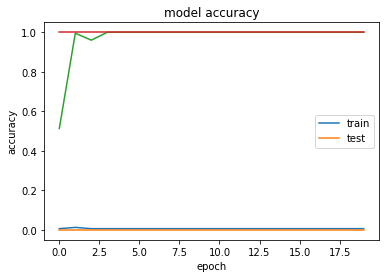

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc_top3'])
plt.plot(history.history['val_acc_top3'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [35]:
i = 0
y_test = []
ref_test= {}
test_imgs = []
for file in os.listdir("CropWithAug/"):
    if( not file.endswith('.jpg')):
        continue;
    yi = int(file.split('_')[0]) - 1 
    img = preprocess_image("CropWithAug/"+ file)[0,:]
    test_imgs.append(img)
    ref_test[i] = file.split('_')[0]
    y_test.append(yi)
X_test = np.array(test_imgs)
y_test = np.array(y_test)

In [38]:
preds = custom_vgg_model.predict(X_test)
test_res = utils.decode_predictions(preds)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 2622)) for V1 or (samples, 8631) for V2.Found array with shape: (1551, 195)

In [39]:
preds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
dtype = [('distance', float), ('index', int)]
m = 0
acc = 0
for test in X_test:
    dist = []
    n = 0
    for train in X_train:
        dist.append((LA.norm(test - train),n))
        n+=1
    a = np.array(dist,dtype=dtype)
    a = np.sort(a,order='distance')[0:30]
    for each in a :
        if ref.get(each[1]) == ref.get(y[m]):
            acc+=1
    m+=1

In [ ]:
a

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
dtype = [('cos', float), ('index', int)]
m = 0
acc_cos = 0
for test in X_test:
    dist = []
    n = 0
    for train in X_train:
        dist.append((cosine(test,train),n))
        n+=1
    a = np.array(dist,dtype=dtype)
    a = np.sort(a,order='cos')[0:50]
    for each in a :
        if ref.get(each[1]) == ref.get(y[m]):
            acc+=1
    m+=1
print(acc_cos)

In [ ]:
epsilon = 0.20

def verifyEar(img1, img2):
    img1_representation = vgg_ear_descriptor.predict(preprocess_image('Cropped/%s' % (img1)))[0,:]
    img2_representation = vgg_ear_descriptor.predict(preprocess_image('Cropped/%s' % (img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('Cropped/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('Cropped/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

In [ ]:
verifyEar("001_.jpg", "005_dt.jpg")